In [1]:
import requests
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

#Reference: https://github.com/alexjungaalto/ResearchPublic/blob/master/ReadPandemic.ipynb

In [2]:
# population data either comes from wikidata or https://www.worldometers.info/world-population/population-by-country/
# Each country's Covid-19 pandemic data can be fetched from wikidata.
covid19Data = {
    'Austria': {'wd_id': 'Q86847911', 'lockdown_date': '2020-03-15', 'population':   8809212},
    'Belgium': {'wd_id': 'Q84446340', 'lockdown_date': '2020-03-13', 'population':  11578789},
    'Bulgaria':{'wd_id': 'Q87486535', 'lockdown_date': '2020-03-13', 'population':   7000039},
    'Croatia': {'wd_id': 'Q87250732', 'lockdown_date': '2020-03-13', 'population':   4105493},
    'Cyprus':  {'wd_id': 'Q87580938', 'lockdown_date': '2020-03-13', 'population':   1207359},
    'Czech':   {'wd_id': 'Q86919406', 'lockdown_date': '2020-03-11', 'population':  10649800},
    "Denmark": {'wd_id': 'Q86597685', 'lockdown_date': '2020-03-16', 'population':   5827463},
    "Estonia": {'wd_id': 'Q87204911', 'lockdown_date': '2020-03-13', 'population':   1326535},
    "Finland": {'wd_id': 'Q84055415', 'lockdown_date': '2020-03-16', 'population':   5540720},
    "France":  {'wd_id': 'Q83873593', 'lockdown_date': '2020-03-16', 'population':  66628000},
    "Germany": {'wd_id': 'Q83889294', 'lockdown_date': '2020-03-13', 'population':  83149300},
    "Greece":  {'wd_id': 'Q87068864', 'lockdown_date': '2020-03-10', 'population':  10423054},
    "Hungary": {'wd_id': 'Q87119811', 'lockdown_date': '2020-03-16', 'population':   9660351},
    "Ireland": {'wd_id': 'Q87186365', 'lockdown_date': '2020-03-13', 'population':   4761865},
    "Italy":   {'wd_id': 'Q84104992', 'lockdown_date': '2020-03-04', 'population':  60317000},
    "Latvia":  {'wd_id': 'Q87066621', 'lockdown_date': '2020-03-12', 'population':   1909000},
    "Lithuania":{'wd_id': 'Q87250838', 'lockdown_date': '2020-03-12', 'population':  2722289}, 
    "Luxembourg":{'wd_id': 'Q87250860', 'lockdown_date': '2020-03-13', 'population':  625978}, 
    "Malta":   {'wd_id': 'Q87587760', 'lockdown_date': '2020-03-12', 'population':    441543}, 
    "Netherlands": {'wd_id': 'Q86756826', 'lockdown_date': '2020-03-12', 'population': 17100715}, 
    "Norway":  {'wd_id': 'Q86886544', 'lockdown_date': '2020-03-12', 'population':   5367580},
    "Poland":  {'wd_id': 'Q87250695', 'lockdown_date': '2020-03-12', 'population':  38433600}, 
    "Portugal": {'wd_id': 'Q86948603', 'lockdown_date': '2020-03-16', 'population': 10600000}, 
    "Romania": {'wd_id': 'Q87250752', 'lockdown_date': '2020-03-11', 'population':  19586539}, 
    "Slovakia": {'wd_id': 'Q87200954', 'lockdown_date': '2020-03-10', 'population':     5439892}, 
    "Slovenia": {'wd_id': 'Q87250948', 'lockdown_date': '2020-03-16', 'population':  2078938}, 
    "Spain":   {'wd_id': 'Q84166704', 'lockdown_date': '2020-03-12', 'population': 46754778}, 
# Sweden never closed primary schools
    "Sweden":  {'wd_id': 'Q84081576', 'lockdown_date': '2020-03-17', 'population':  10099265}, 
    "Switzerland": {'wd_id': 'Q86717788', 'lockdown_date': '2020-03-16', 'population': 8466017},
    "UK":      {'wd_id': 'Q84167106', 'lockdown_date': '2020-03-19', 'population':  66022273}, 
# different state follow different timelines in school closure in the US
    "USA":  {'wd_id': 'Q83873577', 'lockdown_date': '2020-03-16', 'population':    325145963},
#school was on vacations during the outbreak in China
    "China":  {'wd_id': 'Q83872271', 'lockdown_date': '2020-01-23', 'population':    1409517397}, 
  #school was on vacations during the outbreak in South Korea
    "South Korea": {'wd_id': 'Q83872398', 'lockdown_date': '2020-03-', 'population':   51466201},
    "Japan": {'wd_id': 'Q83872291', 'lockdown_date': '2020-03-02', 'population':      126785797}, 
 # School had been mostly open until 2020.04.02 in Singapore.
    "Singapore": {'wd_id': 'Q83873387', 'lockdown_date': '2020-04-03', 'population':    5888926}
}

In [3]:
from datetime import datetime  
from datetime import timedelta

def fetchCovid19Case(wd_id, from_date_str, number_of_days):
    '''fetch the number of newly confirmed cases data since the 'from_date_str' and for the next 'number_of_days' 
    
    Returns:
      An array that contains the daily increase of COVID-19 confirmed cases
    '''
    from_date_object = datetime.strptime(from_date_str, '%Y-%m-%d').date()
    to_date_object = from_date_object + timedelta(days=number_of_days)
    to_date_str = to_date_object.strftime('%Y-%m-%d')

    url = 'https://query.wikidata.org/sparql'
    query = f"""
    SELECT
      ?nrcases ?timepoint
    WHERE {{
      wd:{wd_id} p:P1603 ?p .
      ?p pq:P585 ?timepoint ;
         ps:P1603 ?nrcases .
      FILTER("{from_date_str}"^^xsd:dateTime <= ?timepoint && ?timepoint < "{to_date_str}"^^xsd:dateTime).
    }}
    ORDER BY ASC(?timepoint)
    """

    r = requests.get(url, params={'format': 'json', 'query': query}) #execute the query
    try:
        data = r.json()
    except Exception as ex:
        print(f"failed to parse response as json: {r.text}")
        return None
    # if there are missing data, we'll just skip this country and return None
    if len(data['results']['bindings']) < number_of_days:
        print(f"failed to fetch enough datapoints for {wd_id}. got {len(data['results']['bindings'])}")
        return None 
    
    #print(data['results']['bindings'][0])
    cases = {}
    for i in range(number_of_days):
        date_idx = (datetime.strptime(from_date_str, '%Y-%m-%d').date() + timedelta(days=i)).strftime('%Y-%m-%d')
        cases[date_idx] = None
        
    for item in data['results']['bindings']:
        #print(item['timepoint']['value'])
        timepoint_str = item['timepoint']['value']
        #2020-03-17T00:00:00Z
        timepoint_datestr =datetime.strptime(timepoint_str, '%Y-%m-%dT%H:%M:%SZ').date().strftime('%Y-%m-%d')
        try:
            nrcases = int(item['nrcases']['value'])
        except:
            print(f"failed to parse {item}")
            continue

        if cases[timepoint_datestr] is None:
            cases[timepoint_datestr] = nrcases
        elif nrcases > cases[timepoint_datestr]:            
            # if the time already exists, and the new 'nrcases' is bigger, we use the new 'nrcases' to overwrite the existing one
            if nrcases not in [51100]: # some weird duplicates that we need to skip.
                cases[timepoint_datestr] = nrcases
        pass
        
    # check if there is any date without nrcase.
    for date_str, nrcase in cases.items():
        if nrcase is None:
            print(f"no data reported on {date_str}")
            return None

    df_wikidata=pd.DataFrame.from_records(list(cases.items()), columns =['date', 'nrcases'])

    #print(df_wikidata['nrcases'].values)
    return np.diff(df_wikidata['nrcases'].values)


In [4]:
fetchCovid19Case(covid19Data['Austria']['wd_id'], '2020-03-17',  11)

array([ 314,  367,  375,  426,  430,  680,  952,  684,  838, 1001])

## Fetch the daily increase number from wikidata. 
This is done with best effort, so if some countries has missing datapoint we will just skip it.
The school closure dates in European countries are quite similar to each other. They were all scheduled to start around the weekend of March 15. 
And for the sake of this exercise, I will just pick 2020 March 17 as the starting date and fetch daily increases for next 10 consecutive days. If some data were missing I will skip that country.

In [5]:
import time

for country, country_info in covid19Data.items():
    # instead of using the school closure date, I picked a fixed date, as most EU countries closed school 
    # around the same time frame, i.e. before/after the weekend of 2020-03.15
    print(f"working on {country}")
    daily_increase = fetchCovid19Case(covid19Data[country]['wd_id'], '2020-03-17',  11)
    covid19Data[country]['daily_increase'] = daily_increase
    # sleep a little bit before sending the next request. Otherwise wikidata query service may reject my request
    time.sleep(5)

working on Austria
working on Belgium
failed to fetch enough datapoints for Q84446340. got 5
working on Bulgaria
failed to fetch enough datapoints for Q87486535. got 1
working on Croatia
failed to fetch enough datapoints for Q87250732. got 2
working on Cyprus
failed to fetch enough datapoints for Q87580938. got 2
working on Czech
working on Denmark
failed to fetch enough datapoints for Q86597685. got 6
working on Estonia
failed to fetch enough datapoints for Q87204911. got 3
working on Finland
failed to fetch enough datapoints for Q84055415. got 4
working on France
working on Germany
working on Greece
failed to fetch enough datapoints for Q87068864. got 4
working on Hungary
working on Ireland
failed to parse {'nrcases': {'type': 'bnode', 'value': 't1958263443'}, 'timepoint': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '2020-03-17T00:00:00Z'}}
failed to parse {'nrcases': {'type': 'bnode', 'value': 't1958263433'}, 'timepoint': {'datatype': 'http:

## Find the countries with meaningful daily increase number from wikidata. We will only analyze those
We use the number of new Covid-19 cases per 100K population in the feature vector. i.e. the feature vector for each country
is the number of new cases per 100K population from 2020-03-18 to 2020-03-27.

In [6]:
# country names
countryLabels = []
# daily increase of Covid-19 cases per 100K population
dailyIncreasePer100K = []
for country, countryInfo in covid19Data.items():
    if countryInfo['daily_increase'] is not None:
        countryLabels.append(country)
        dailyIncreasePer100K.append(np.divide(countryInfo['daily_increase'], countryInfo['population']/100000 ))

Z = np.array(dailyIncreasePer100K)
Z.shape



(17, 10)

**So in the end, we got 17 countries left for analysis.**

In [7]:
for country, increase in zip(countryLabels, dailyIncreasePer100K):
    print(f"{country}: {increase}")

Austria: [ 3.56445049  4.1660934   4.25690743  4.83584684  4.88125385  7.71919214
 10.80686899  7.76459915  9.51276913 11.3631049 ]
Czech: [1.03288325 1.92491878 1.16434111 1.48359594 1.10800203 1.14556142
 1.73712182 2.73244568 2.43197055 3.50241319]
France: [2.10722219 2.79312001 2.42690761 2.77210782 3.34694123 4.75325689
 3.67112925 4.39905145 5.88641412 5.71681575]
Germany: [1.2531675  3.3686393  8.80825214 3.77633967 3.98199384 5.33738709
 2.81662022 5.95795755 6.95135136 7.56951652]
Hungary: [0.08281273 0.15527386 0.12421909 0.18632863 0.28984454 0.37265727
 0.20703181 0.40371204 0.36230568 0.40371204]
Italy: [ 6.97481639  8.82338313  9.92423363 10.87089875  9.21796508  7.93971849
  8.70235589  8.6376975  10.20110417  9.87947013]
Luxembourg: [10.06425146 21.08700306 23.80275345 29.71350431 20.44800296 12.30075178
 35.78400519 37.38150542 19.17000278 24.28200352]
Netherlands: [2.02330721 2.39171286 3.12267645 3.72499045 3.35073709 3.18700125
 4.74249176 4.98224782 5.95881517 6.85

## Cluster analysis 
### First, let's try to find the number of clusters

Clustering errors: 
[[372.98790041]
 [116.44131822]
 [ 42.71794933]
 [ 19.22049211]
 [ 10.61083353]
 [  6.82897086]
 [  3.80305313]
 [  1.42176723]]


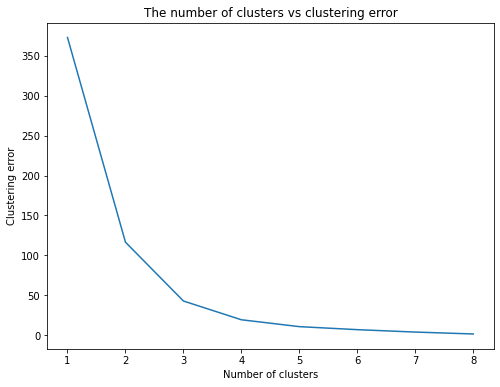

In [8]:
m = Z.shape[0]    # Number of data points
err_clustering = np.zeros((8,1))    # Array for storing clustering errors

L=100
for k_minus_1 in range(8):
    k_means = KMeans(n_clusters = k_minus_1+1, max_iter = L).fit(Z)
    err_clustering[k_minus_1] = 1/m * k_means.inertia_
    

print(f'Clustering errors: \n{err_clustering}')

# Plot the clustering error as a function of the number k of clusters
plt.figure(figsize=(8,6))
plt.plot(range(1,9), err_clustering)
plt.xlabel('Number of clusters')
plt.ylabel('Clustering error')
plt.title("The number of clusters vs clustering error")
plt.show()   

### From the above graph, It seems 3~4 cluster are the most appropriate. Let's do the K-Means clustering on Z, with 4 clusters

In [11]:
k = 4    # Define number of clusters to use

k_means = KMeans(n_clusters = k, max_iter = 100).fit(Z)  # Apply k-means with k=4 cluster and using maximum 100 iterations
cluster_means = k_means.cluster_centers_    # Get cluster means (centers)
cluster_indices = k_means.labels_           # Get the cluster labels for each data point

#print the cluster labels and the relevant countries
clusters={}
for country, idx in zip(countryLabels, cluster_indices):
    if idx not in clusters:
        clusters[idx] = [country]
    else:
        clusters[idx].append(country)

import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(clusters)

{   0: ['Czech', 'Hungary', 'Poland', 'UK', 'China', 'South Korea', 'Japan'],
    1: ['Luxembourg'],
    2: ['Austria', 'Italy', 'Spain'],
    3: ['France', 'Germany', 'Netherlands', 'Norway', 'Portugal', 'USA']}


### Let's do PCA to transform the original data Z with 10 features into X with 2 features and then plot these countries

In [12]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
n = 2  # Define number of principal components

pca = PCA(n_components=n)    # Define pca object with n components
pca.fit(Z)    # Fit pca object on Z
W_pca = pca.components_
# Now the principle components becomes X
X = pca.transform(Z)
# reconstruct from X to get Z_hat
Z_hat = pca.inverse_transform(X)
# Now calculating err_pca
err_pca = mean_squared_error(Z, Z_hat)*len(Z[0])

#raise NotImplementedError()

print(f'Shape of Z: {Z.shape}')
print(f'Shape of X: {X.shape}')
print(f'Shape of compression matrix W: {W_pca.shape}')
print(f'PCA error: {err_pca}')

Shape of Z: (17, 10)
Shape of X: (17, 2)
Shape of compression matrix W: (2, 10)
PCA error: 7.975148850307083


In [18]:
def plottingCluster(data, centroids=None, clusters=None):
    # This function will later on be used for plotting the clusters and centroids. But now we use it to just make a scatter plot of the data
    # Input: the data as an array, cluster means (centroids), cluster assignemnts in {0,1,...,k-1}   
    # Output: a scatter plot of the data in the clusters with cluster means
    plt.figure(figsize=(12,12))
    data_colors = ['orangered', 'dodgerblue', 'springgreen', 'blueviolet', 'gold']
    centroid_colors = ['red', 'darkblue', 'limegreen', 'violet', 'yellow'] # Colors for the centroids
    plt.style.use('ggplot')
    plt.title("PCA transformed data")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

    alp = 0.5             # data points alpha
    dt_sz = 20            # marker size for data points 
    cent_sz = 130         # centroid sz 
    
    if centroids is None and clusters is None:
        plt.scatter(data[:,0], data[:,1],s=dt_sz,alpha=alp ,c=data_colors[0])
    if centroids is not None and clusters is None:
        plt.scatter(data[:,0], data[:,1],s=dt_sz,alpha=alp, c=data_colors[0])
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", s=cent_sz, c=centroid_colors[:len(centroids)])
    if centroids is not None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i] for i in clusters], s=dt_sz, alpha=alp)
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", c=centroid_colors[:len(centroids)], s=cent_sz)
    if centroids is None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i-1] for i in clusters], s=dt_sz, alpha=alp)
 
    for x,y,label in zip(data[:,0],data[:,1],countryLabels):
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,5), # distance from text to points (x,y)
                     ha='center',fontsize=10) # horizontal alignment can be left, right or center
    plt.show()



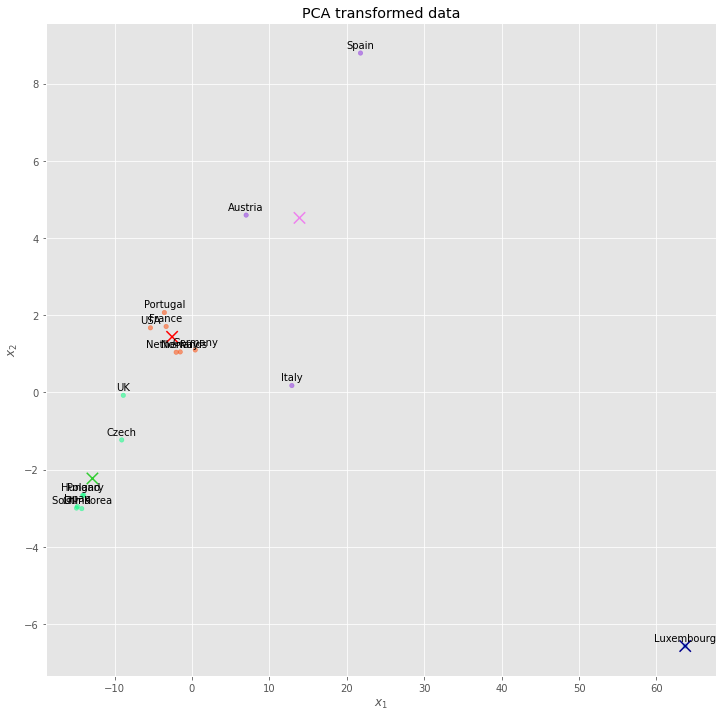

{   0: ['France', 'Germany', 'Netherlands', 'Norway', 'Portugal', 'USA'],
    1: ['Luxembourg'],
    2: ['Czech', 'Hungary', 'Poland', 'UK', 'China', 'South Korea', 'Japan'],
    3: ['Austria', 'Italy', 'Spain']}


In [21]:
m, n = X.shape    # Get the number of data points m and number of features n

k = 4    # Define number of clusters to use

cluster_means = np.zeros((k,n))    # Store the resulting clustering means in the rows of this np array
cluster_labels = np.zeros(m)    # Store here the resulting cluster indices (one for each data point)

k_means = KMeans(n_clusters = k, max_iter = 100).fit(X)  # Apply k-means with k=3 cluster and using maximum 100 iterations
cluster_means = k_means.cluster_centers_    # Get cluster means (centers)
cluster_indices = k_means.labels_           # Get the cluster labels for each data point

# Plot the clustered data
plottingCluster(X, centroids=cluster_means, clusters=cluster_indices)

#print the cluster labels
clusters={}
for country, idx in zip(countryLabels, cluster_indices):
    if idx not in clusters:
        clusters[idx] = [country]
    else:
        clusters[idx].append(country)

import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(clusters)


### Some intepretation of the data.
It is easy to see that clustering on the original data Z and PCA transformed data X generates the same clustering results.
I assume the two primary components of each data point maily cover two aspects of the pandemic:
* The number of newly confirmed cases per 100K population. 
* The changes in the daily increase (i.e. is it increasing or decreasing or relatively stable)

In the period of 2020.03.18~2020.03.28
* For countries like Luxembourg and Spain, their per 100K newly confirmed cases are quite big, so they stand out, on the X_1 axis.
* For countries where the number of new cases keeps increasing at a fast pace, they stand out on the X_2 axis, such as Austria and Spain.
* Countries like 'USA' and 'France', their number of daily increase is not very high yet (per population), but the trend is accelerating.
* There are countries like China and South Korea and Japan where the pandemic looks more or less under control as exhibited by low number of newly increase per 100K population as well as the changes in the newly affected cases doesn't have a increasing trend.

Based on the analyzed timewindow, if the COVID-19 testing has been sufficient among the population and the numbers truly reflect the pandemic situation, then we can draw the conclusion that if one lives in the last cluster (which includes countries like 'Czech', 'Hungary', 'Poland', 'UK', 'China', 'South Korea', 'Japan'), then the risk to contract COVID-19 is the lowest.